In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

In [ ]:
# Prepare the data for clustering
# Aggregate transaction data to create features like total value and frequency
customer_transactions = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Frequency of transactions
    'TotalValue': 'sum',  # Total spending
}).reset_index().rename(columns={'TransactionID': 'TransactionCount'})

In [ ]:
# Merge with customer profile data
customer_data = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)

# Encode categorical variables (Region)
customer_data_encoded = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

In [ ]:
# Standardize numerical features for clustering
scaler = StandardScaler()
numeric_columns = ['TransactionCount', 'TotalValue']
scaled_data = scaler.fit_transform(customer_data_encoded[numeric_columns])

In [ ]:
# Apply KMeans clustering (experimenting with 2 to 10 clusters)
results = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, labels)
    results[n_clusters] = {'model': kmeans, 'labels': labels, 'db_index': db_index}

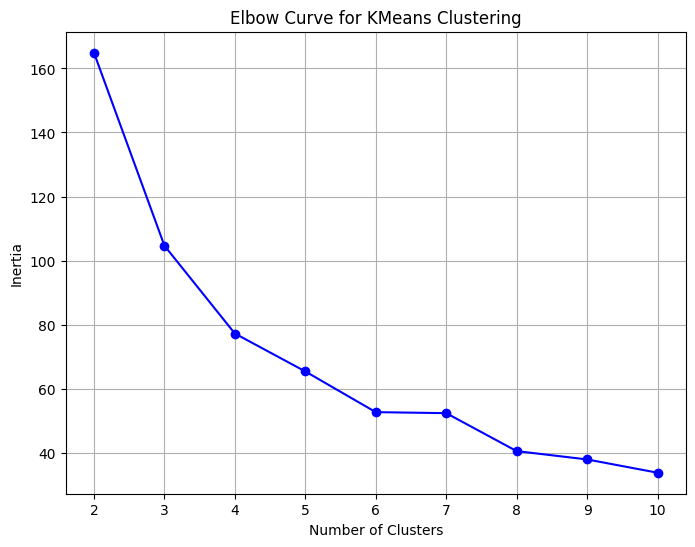

In [25]:
# Plot the elbow curve for KMeans clustering
inertia_values = []

# Calculate inertia (sum of squared distances to centroids) for different numbers of clusters
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Curve for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [26]:
# Identify the optimal number of clusters based on the lowest DB Index
optimal_clusters = 3
optimal_model = results[optimal_clusters]['model']
optimal_labels = results[optimal_clusters]['labels']
optimal_db_index = results[optimal_clusters]['db_index']

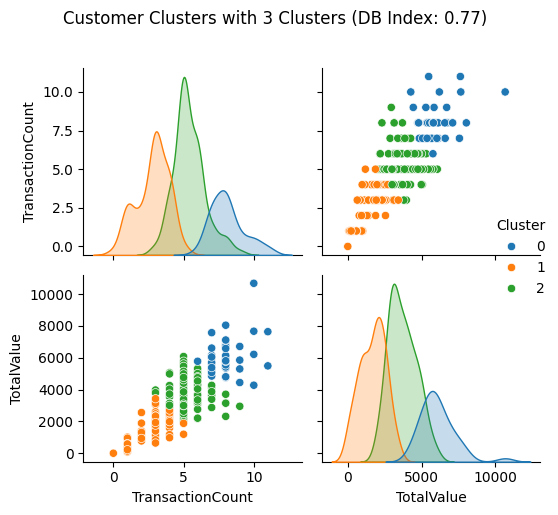

In [27]:
# Add cluster labels to customer data
customer_data['Cluster'] = optimal_labels

# Visualize the clusters using pairplot
sns.pairplot(customer_data_encoded.assign(Cluster=optimal_labels), vars=numeric_columns, hue='Cluster', palette='tab10')
plt.suptitle(f'Customer Clusters with {optimal_clusters} Clusters (DB Index: {optimal_db_index:.2f})', y=1.02)
plt.tight_layout()
plt.show()



In [28]:
# Display clustering metrics
optimal_clusters, optimal_db_index

(3, 0.7666651493492401)